In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.misc import comb

#plt.style.use('ggplot')

thor=pd.read_csv('data/thor_edited.csv') #import data

rez=600

/Users/danielreeves/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
def get_patient_info(p):
    if p=='B1':
        
        #temporary data fram
        tdf=thor[thor['ppt1']=='B1']
        
        #get unique values
        tl = tdf['time1'].unique()
                      
        #specific grouping for B1
        plist = [tdf[(tdf['time1']==tl[0])],
              tdf[(tdf['time1']==tl[1]) | (tdf['time1']==tl[2])],
              tdf[(tdf['time1']==tl[3]) | (tdf['time1']==tl[4])]] 

        cz='slateblue'
        csubs=['navy','slateblue','steelblue']
        mz='o'
        group_list=['1.1','6.3-7.1','11.3-12.7']
        times_avg=[1.1,6.8,12]
        
    if p=='L1':
        
        tdf= thor[thor['ppt1']==p]
        tl = tdf['time1'].unique()
                      
        #specific grouping for B1
        plist = [tdf[(tdf['time1']==tl[0]) | (tdf['time1']==tl[1])],
                  tdf[tdf['time1']==tl[2]],
                  tdf[tdf['time1']==tl[3]]]
        cz='limegreen'
        csubs=['darkgreen','olivedrab','limegreen']
        mz='s'
        group_list=['1.0-1.3','4.1','11.8']
        times_avg=[1.1,4,12]

    if p=='R1':
        
        tdf= thor[thor['ppt1']==p]
        tl = tdf['time1'].unique()
              
        #specific grouping for B1
        plist = [tdf[tdf['time1']==tl[0]],
                 tdf[tdf['time1']==tl[1]],
                 tdf[tdf['time1']==tl[2]]]
        cz='indianred'
        csubs=['tomato','peru','pink']
        mz='^'
        times_avg=[1.8,8.2,12.3] 
        group_list=['1.8','8.2','12.3']

    return tl,plist,cz,csubs,mz,times_avg,group_list

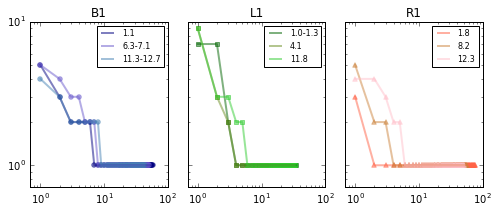

In [7]:
#grouped data rank abundance plots
fig,axarr = plt.subplots(1,3,sharex=True, sharey=True,figsize=(7,3),dpi=rez)
in_p=0
u_rat=[[],[],[]]
u_t=[]
q_list=[]
for p in thor['ppt1'].unique():
        
    tl,plist,cz,csubs,mz,times_avg,group_list = get_patient_info(p)
    
    for tp in range(len(plist)): #with grouped time intervals

        genes = plist[tp]['gene1'].value_counts()
        
        clones = np.asarray(genes)[1:] #might have to be careful with 'X'
        
        true_clones = np.append(clones,np.ones([genes['X'],1])) #append on the unknown clones

        u_rat[in_p].append(sum(true_clones==1)/sum(true_clones))
        u_t.append(times_avg)
        
        q_list.append(true_clones)
        
        axarr[in_p].plot(np.arange(1,len(true_clones)+1),true_clones,alpha=0.5,color=csubs[tp],lw=2)
        axarr[in_p].scatter(np.arange(1,len(true_clones)+1),true_clones,alpha=0.5,color=csubs[tp],marker=mz)#,where='pre')
        axarr[in_p].legend(group_list,fontsize=8)
        
    axarr[in_p].set_title(p)
    in_p+=1

axarr[0].set_xscale('log')
axarr[0].set_yscale('log')    
axarr[0].set_xlim([0.7,100])
axarr[0].set_ylim([0.7,10])
#axarr[0].set_ylabel('abundance')
#axarr[1].set_xlabel('rank')

plt.tight_layout()

plt.savefig('figures/rank_abundance_grouped.pdf')


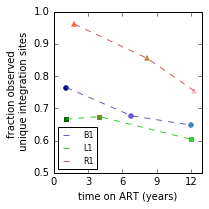

In [8]:
#percent of clones unique
plt.figure(figsize=(3,3),dpi=rez)

c_list=['slateblue','limegreen','indianred']
m_list=['o','s','^']
inp=0
for p in thor['ppt1'].unique():
    tl,plist,cz,csubs,mz,times_avg,group_list = get_patient_info(p)
    plt.plot(times_avg,u_rat[inp],color=c_list[inp],ls='--')
    for j in range(3):
        plt.scatter(times_avg[j],u_rat[inp][j],color=csubs[j],marker=m_list[inp])
    inp+=1
plt.ylim([0.5,1])
plt.xticks(np.linspace(0.8,1,5))
plt.xticks(np.linspace(0,15,6))
plt.xlabel('time on ART (years)')    
plt.ylabel('fraction observed \n unique integration sites') 
plt.xlim([0,13])
plt.tight_layout()
plt.legend(['B1','L1','R1'],fontsize=8,loc=3)
plt.savefig('figures/unique_data.pdf')

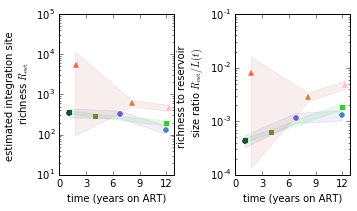

In [46]:
def chao1(true_clones):
    Robs = len(true_clones)
    n = sum(true_clones)

    f1=sum(true_clones==1)
    f2=sum(true_clones==2)
        
    Rest = Robs + (1-1./n)*f1*(f1-1)/(2*f2+1)
        
    if f2!=0:
        rf=(f1/f2)
        varR = f2*(rf**4/4 + rf**3 + rf**2/2)
    else:
        varR=Robs
        
    c=np.exp(1.96*np.sqrt(np.log(1+varR/(Rest-Robs)**2)))

    C=(Rest-Robs)/c
    
    return Rest,C

R=np.zeros([3,3])
C=np.zeros([3,3])

#use chao1 to estimate richness and her other paper for the diversity
plt.figure(figsize=(5,3),dpi=rez)
aopts=np.zeros([3,3])
for in_p in range(3):
    
    tl,plist,cz,csubs,mz,times_avg,group_list = get_patient_info(thor['ppt1'].unique()[in_p])
    
    #loop through each grouped person
    for tp in range(len(plist)): #with grouped time intervals

        genes = plist[tp]['gene1'].value_counts()
        
        clones = np.asarray(genes)[1:] #might have to be careful with 'X'
        
        true_clones = np.append(clones,np.ones(genes['X'])) #append on the unknown clones

        Rest,Cest=chao1(true_clones) #estimate richness
        
        R[in_p][tp]=Rest
        C[in_p][tp]=Cest
        
    plt.subplot(121)
    plt.fill_between(times_avg,R[in_p]-C[in_p],R[in_p]+C[in_p],color=cz,alpha=0.1)
    for j in range(3):
        plt.scatter(times_avg[j],R[in_p,j],color=csubs[j],marker=m_list[in_p])

    plt.xlabel('time (years on ART)')
    plt.ylabel('estimated integration site \n richness $R_\mathrm{est}$')
    plt.yscale('log')
    plt.xticks(np.linspace(0,12,5))

    L=1e6*np.exp(-5.2e-4*np.array(times_avg)*365) #calculate the resrevoir size
    
    plt.subplot(122)
    plt.fill_between(times_avg,(R[in_p]-C[in_p])/L,(R[in_p]+C[in_p])/L,color=cz,alpha=0.1)
    for j in range(3):
        plt.scatter(times_avg[j],R[in_p,j]/L[j],color=csubs[j],marker=m_list[in_p])
    plt.xlabel('time (years on ART)')
    plt.ylabel('richness to reservoir \n size ratio' + r' $R_\mathrm{est}/L(t)$')
    plt.yscale('log')
    plt.xticks(np.linspace(0,12,5))
    
    in_p+=1
    
#plt.legend(['B1','L1','R1'],fontsize=8,loc=1)
plt.tight_layout()
plt.savefig('figures/richness_over_time.pdf')

In [10]:
R

array([[  348.33333333,   317.12747253,   132.84330484],
       [  358.77777778,   296.37209302,   193.01666667],
       [ 5554.84615385,   598.30967742,   458.21311475]])

In [38]:
marker_list=['o', 'o', 'o', 's', 's', 's', '^', '^', '^']
color_list=['navy','slateblue','steelblue', 
            'darkgreen','olivedrab', 'limegreen',
            'pink', 'peru','tomato']


In [20]:
#now rarefaction

def rarefact(true_clones):

    R=len(true_clones)
    N=sum(true_clones)

    Rn=np.zeros(R)
    nl=np.arange(1,R+1)

    for n in nl:
        ss=[]
        for j in range(len(true_clones)):
            ss.append(comb(N-true_clones[j],n))

        Rn[n-1]=(R - sum(ss)/comb(N,n))
    
    return nl,Rn

#species accumulation
def accumulate(dist,max_s):
    s_list=[]
    s=0
    curve=[]
    while s<max_s:
        draw = sample_distribution(dist/sum(dist),1)

        if draw not in s_list:
            s+=1

        s_list.append(draw)
        curve.append(s)
    
    return np.arange(1,len(curve)+1),np.array(curve)

#newer one
def rarefaction(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        ss=0 #the sum
        for j in range(R):
            ss+=comb(L-abundance[j],n)
            
        r_list[n-1]=R-ss/comb(L,n)
    return n_list,r_list

#function that calculates rarefaction curve based on rank and abundance data
def rarefaction_approx(rank,abundance,num_samples):

    R=len(abundance)
    L=sum(abundance)

    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        r_list[n-1]=R-np.sum((1-abundance/L)**n)
    return n_list,r_list

#generate random samples from distribution
def sample_distribution(dist,num_samples):
    custm = stats.rv_discrete(name='custm', values=(np.arange(1,len(dist)+1), dist/sum(dist)))
    sim_samples = custm.rvs(size=num_samples)
    return sim_samples


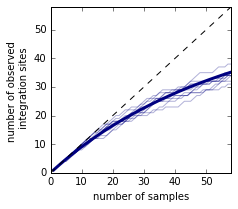

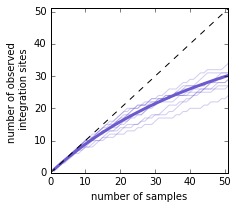

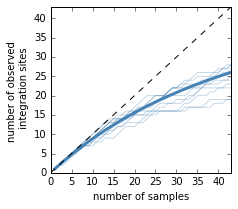

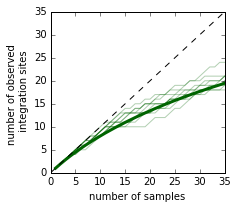

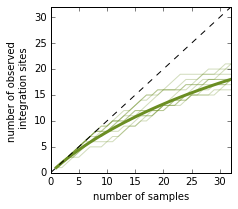

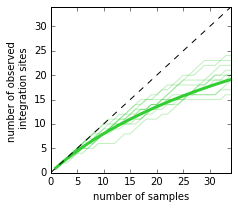

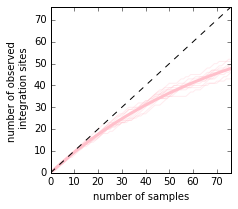

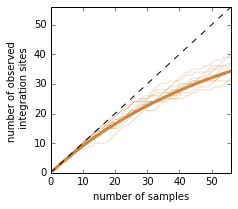

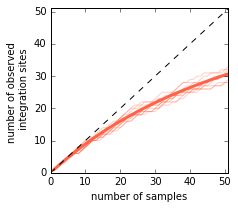

In [43]:
#show examples of species accumulation and rarefaction

for pat in range(9):

    plt.figure(figsize=(3.4,3),dpi=rez)
    dist=q_list[pat]
    max_s=len(dist)

    for i in range(10):
        samples, species = accumulate(dist,max_s)
        plt.plot(samples,species,color=color_list[pat],alpha=0.3,lw=1)

    exp_samples, exp_species=rarefaction_approx(samples,dist,max(samples))
    plt.plot(exp_samples,exp_species,lw=3,color=color_list[pat])
    plt.xlim([0,max_s])
    plt.ylim([0,max_s])
    plt.plot(np.linspace(0,max_s,5),np.linspace(0,max_s,5),ls='--',color='black')

    plt.xlabel('number of samples')
    plt.ylabel('number of observed \n integration sites')
    
    plt.tight_layout()
    plt.savefig('figures/rarefaction_example'+str(pat)+'.pdf')

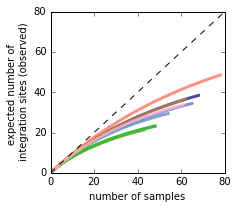

In [44]:
#rarefaction from data
plt.figure(figsize=(3.4,3),dpi=rez)
for in_p in range(3):
    
    tl,plist,cz,csubs,mz,times_avg,group_list = get_patient_info(thor['ppt1'].unique()[in_p])
    
    #loop through each grouped person
    for tp in range(len(plist)): #with grouped time intervals

        genes = plist[tp]['gene1'].value_counts()        
        true_clones = np.append(np.asarray(genes)[1:],np.ones(genes['X'])) #append on the unknown clones

        nl,Rn = rarefaction_approx(np.arange(1,len(true_clones)+1),true_clones,num_samples=int(sum(true_clones)))
                
        plt.plot(nl,Rn,color=csubs[tp],lw=3,alpha=0.7)
    plt.xlabel('number of samples')
    plt.ylabel('expected number of \n integration sites (observed)')

#plt.axis('equal')
#plt.grid()
#plt.axis([-3, 3, -3, 3])
plt.plot(np.linspace(0,80,5),np.linspace(0,80,5),ls='--',color='black')
plt.yticks(np.linspace(0,80,5))
plt.xticks(np.linspace(0,80,5))
plt.tight_layout()
plt.savefig('figures/rarefaction.pdf')

In [59]:
true_clones

array([ 4.,  4.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [60]:
nl

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [61]:
len(true_clones)

51